In [3]:
# All project code without other things
%matplotlib inline
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import cv2

dataset_path = '/dtu/datasets1/02514/data_wastedetection'
anns_file_path = dataset_path + '/' + 'annotations.json'

# Read annotations
with open(anns_file_path, 'r') as f:
    dataset = json.loads(f.read())
    
from copy import deepcopy
import colorsys
from matplotlib.patches import Polygon, Rectangle


def get_image_ground_truth(filename):
    #----------------------------------------------
    # Function to find the ground truth annotation for each resized image 
    #----------------------------------------------

    # Find the image id in the annotation file
    for img in dataset['images']:
        if img['file_name'] == filename:
            my_img = deepcopy(img)

    w_factor = float(image_size)/my_img['width']
    h_factor = float(image_size)/my_img['height']

    # Finding all the annotations for one image - maybe try to optimize it by using pandas?
    img_annots = {}
    img_annots['id'] = []
    img_annots['bbox'] = []
    img_annots['category_id'] = []
    img_annots['supercategory'] = []
    for annot in dataset['annotations']:
        if annot['image_id'] == my_img['id']:
            #print(annot['id'], annot['bbox'], annot['category_id'])#, dataset['categories']['id'][annot['id']])
            img_annots['id'].append(annot['id'])
            img_annots['bbox'].append([round(annot['bbox'][0]*w_factor,1), round(annot['bbox'][1]*h_factor,1), round(annot['bbox'][2]*w_factor,1), round(annot['bbox'][3]*h_factor,1)])
            img_annots['category_id'].append(annot['category_id'])
            for cat in dataset['categories']:
                if cat['id'] == annot['category_id']:
                    #print(cat['supercategory'])
                    img_annots['supercategory'].append(cat['supercategory'])
                    
    return img_annots
                         
# All the images have to be resized to the standard size and hence the annotation boxes coordinates
# [x, y, w, h] = ann['bbox']

def get_image_proposals(filepath):
    # Get the proposals for an image
    image = cv2.imread(filepath)
    image = cv2.resize(image,(image_size,image_size))
    ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
    ss.setBaseImage(image)
    ss.switchToSelectiveSearchFast()
    prop = ss.process()[:2000]
    return prop


def get_iou(bb1, bb2):
    # bb1 = [x1 y1 w1 h1]
    # bb2 = [x2 y2 w2 h2]
    
    #x1_bb1 = bb1[0]
    #y1_bb1 = bb1[1]
    #x2_bb1 = bb1[0] + bb1[2]
    #y2_bb1 = bb1[1] + bb1[3]
    
    #x1_bb2 = bb2[0]
    #y1_bb2 = bb2[1]
    #x2_bb2 = bb2[0] + bb2[2]
    #y2_bb2 = bb2[1] + bb2[3]
    
    # assuring for proper dimension.
    assert bb1[0] < bb1[0] + bb1[2]
    assert bb1[1] < bb1[1] + bb1[3]
    assert bb2[0] < bb2[0] + bb2[2]
    assert bb2[1] < bb2[1] + bb2[3]
    # calculating dimension of common area between these two boxes.
    x_left = max(bb1[0], bb2[0])
    y_top = max(bb1[1], bb2[1])
    x_right = min(bb1[0] + bb1[2], bb2[0] + bb2[2])
    y_bottom = min(bb1[1] + bb1[3], bb2[1] + bb2[3])
    # if there is no overlap output 0 as intersection area is zero.
    if x_right < x_left or y_bottom < y_top:
        return 0.0
    # calculating intersection area.
    intersection_area = (x_right - x_left) * (y_bottom - y_top)
    # individual areas of both these bounding boxes.
    bb1_area = (bb1[2]) * (bb1[3])
    bb2_area = (bb2[2]) * (bb2[3])
    # union area = area of bb1_+ area of bb2 - intersection of bb1 and bb2.
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

def assign_category_to_proposal(prop, img_annots):
    assignemt_prob = np.zeros([len(prop),len(img_annots['id'])])

    for i in range(len(prop)):
        for j in range(len(img_annots['bbox'])):
            assignemt_prob[i,j] = get_iou(np.array(prop[i]),np.array(img_annots['bbox'][j]))
            
    prop_categories = np.empty(len(prop))

    for i in range(len(prop)):
        if not (assignemt_prob[i,:] > 0.5).any(): 
            prop_categories[i] = 999
        else:
            index = np.argmax(assignemt_prob[i,:])
            prop_categories[i] = img_annots['category_id'][index]
            
    return prop_categories

def crop_images_to_proposals(filepath, prop, new_image_size):
    image = cv2.imread(filepath)
    image = cv2.resize(image,(image_size,image_size))
    cropped_resized_images = []
    for box in prop:
        cropped_image = image[box[1]:box[1]+box[3],box[0]:box[0] + box[2]]
        
        cropped_resized_images.append(cv2.resize(cropped_image,(image_size,image_size)))
    
    return cropped_resized_images


In [19]:
image_size = 224
cropped_image_size = 64

file_name = 'batch_11/000028.jpg'
file_path = '/dtu/datasets1/02514/data_wastedetection/'

image = cv2.imread(file_path + file_name)
image = cv2.resize(image,(image_size,image_size))

img_annots = get_image_ground_truth(file_name)
prop = get_image_proposals(file_path + file_name)
prop_categories = assign_category_to_proposal(prop, img_annots)
cropped_resized_images = crop_images_to_proposals(file_path + file_name, prop, new_image_size=cropped_image_size)

# Images and labels for one picture
data = (cropped_resized_images, prop_categories)

In [ ]:
data_images = []
data_labels = []
# Create the entire dataset by looping over all images
for img in dataset['images']:
    file_name = img['file_name']
    img_annots = get_image_ground_truth(file_name)
    prop = get_image_proposals(file_path + file_name)
    prop_categories = assign_category_to_proposal(prop, img_annots)
    cropped_resized_images = crop_images_to_proposals(file_path + file_name, prop, new_image_size=cropped_image_size)

    data_images = data_images + cropped_resized_images
    data_labels = data_labels + list(prop_categories)


In [ ]:
# Load the dataset here 

# Plots - for understanding

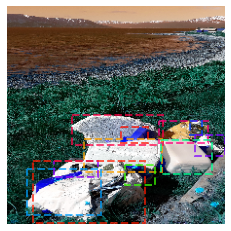

In [7]:
fig,ax = plt.subplots(1)
plt.axis('off')
plt.imshow(image)

# Show annotations
for box in img_annots['bbox']:
    #print(box)
    color = colorsys.hsv_to_rgb(np.random.random(),1,1)
    
    rect = Rectangle((box[0],box[1]),box[2],box[3],linewidth=2,edgecolor=color,
                    facecolor='none', alpha=0.7, linestyle = '--')
    ax.add_patch(rect)

plt.show()

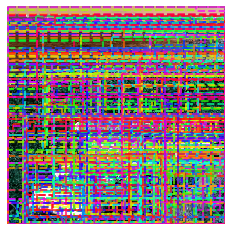

In [8]:
fig,ax = plt.subplots(1)
plt.axis('off')
plt.imshow(image)

# Show annotations
for box in prop:
    #print(box)
    color = colorsys.hsv_to_rgb(np.random.random(),1,1)
    
    rect = Rectangle((box[0],box[1]),box[2],box[3],linewidth=2,edgecolor=color,
                    facecolor='none', alpha=0.7, linestyle = '--')
    ax.add_patch(rect)

plt.show()

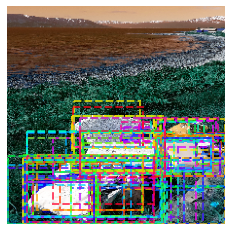

In [9]:
fig,ax = plt.subplots(1)
plt.axis('off')
plt.imshow(image)

# Show annotations
j = 0
for box in prop:
    if prop_categories[j] != 999:
        #print(box)
        color = colorsys.hsv_to_rgb(np.random.random(),1,1)

        rect = Rectangle((box[0],box[1]),box[2],box[3],linewidth=2,edgecolor=color,
                        facecolor='none', alpha=0.7, linestyle = '--')
        ax.add_patch(rect)
    j+=1

plt.show()

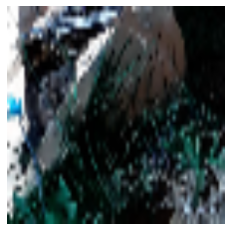

In [10]:
# Plot one of the cropped and resized images
fig,ax = plt.subplots(1)
plt.axis('off')
plt.imshow(cropped_resized_images[15])